In [63]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import copy
import matplotlib.pyplot as plt

# Generate Data

In [189]:
#Import data
data = pd.read_csv('./data/melanoma.csv')
t = np.array(data['t'])
delta = np.array(data['delta'])
x = np.array(data['x'])

#Normalize
scale = (np.sum(t)/np.sum(delta))
t_norm = t/scale
mean_x = np.mean(x)
std_x = np.std(x)
x_norm =(x- mean_x)/std_x

#Randomize
np.random.seed(120)
n = np.shape(t_norm)[0]
ind = np.random.permutation(np.arange(n))
t_norm = t_norm[ind]
delta = delta[ind]
x_norm = x_norm[ind]

# Nonparametric Predictive

/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1335a3340> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x133596dc0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x13359cf70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


Text(0, 0.5, 'Survival Function')

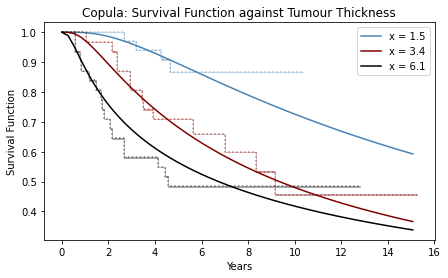

In [190]:
from lifelines import KaplanMeierFitter
f =plt.figure(figsize=(7,4))
x_val = (np.array([1.5,3.4,6.1]))
y_plot = np.load('plot_files/melanoma_y_plot.npy')
col = ['steelblue','maroon','k']

x_ranges= ([(1.255,1.75),(2.7,4.1),(4.1,8.1)]-mean_x)/std_x
for i in range(3):
    x_norm_ = (x_val[i]- mean_x)/std_x
    logcdf_av = np.load("plot_files/melanoma_logcdf_av_copula_x{}.npy".format(x_val[i]))

    #cdf
    plt.plot(y_plot*scale/365,1-np.exp(logcdf_av),label = 'x = {:.1f}'.format(x_val[i]),color = col[i])
    
    kmf = KaplanMeierFitter(alpha = 0.99)
    ind_x = np.where(np.logical_and(x_norm>x_ranges[i,0], x_norm<x_ranges[i,1]))
    kmf.fit(t_norm[ind_x]*scale/365,event_observed = delta[ind_x])
    kmf.plot(linestyle = ':',alpha = 0.5,color = col[i],label='_nolegend_')
plt.legend()
plt.title('Copula: Survival Function against Tumour Thickness')
plt.xlabel('Years')
plt.ylabel('Survival Function')
#f.savefig("plots/melanoma_surv_KM.pdf",bbox_inches='tight')


## Supplementary Plots

In [191]:
#Load copula
ESS_copula = np.load('plot_files/melanoma_ESS_copula.npy')
particle_ind_copula = np.load('plot_files/melanoma_particle_ind_copula.npy')
logpdf_av_copula = np.load('plot_files/melanoma_logpdf_av_copula_x3.4.npy')
logcdf_av_copula = np.load('plot_files/melanoma_logcdf_av_copula_x3.4.npy')
logpdf_pr_copula = np.load('plot_files/melanoma_logpdf_samp_copula.npy')
logcdf_pr_copula = np.load('plot_files/melanoma_logcdf_samp_copula.npy')
pdiff_copula = np.load('plot_files/melanoma_pdiff_copula.npy')
cdiff_copula = np.load('plot_files/melanoma_cdiff_copula.npy')
rho_opt_copula = np.load('plot_files/melanoma_rho_copula.npy')
rho_x_copula = np.load('plot_files/melanoma_rhox_copula.npy')
median_fun = np.load('plot_files/melanoma_median_fun.npy')
x_grid =np.load('plot_files/melanoma_x_grid.npy')
y_plot = np.load('plot_files/melanoma_y_plot.npy')


pdf_av_copula = np.exp(logpdf_av_copula)
cdf_av_copula = np.exp(logcdf_av_copula)
pdf_pr_copula = np.exp(logpdf_pr_copula)
cdf_pr_copula = np.exp(logcdf_pr_copula)

#Fix lognormal density starting at 0
pdf_av_copula[0] = 0
pdf_pr_copula[:,0] = 0

#Load DPMM
pdf_ddp = np.array(pd.read_csv("plot_files/melanoma_pdf_ddp_x3.4.csv").iloc[:,1])
cdf_ddp = np.array(pd.read_csv("plot_files/melanoma_cdf_ddp_x3.4.csv").iloc[:,1])
x_grid_ddp = np.array(pd.read_csv("plot_files/melanoma_x_grid_ddp.csv").iloc[:,1])
y_plot_ddp = np.array(pd.read_csv('plot_files/melanoma_y_plot_ddp.csv').iloc[:,1])
median_fun_ddp = np.array(pd.read_csv('plot_files/melanoma_median_fun_ddp.csv').iloc[:,1])

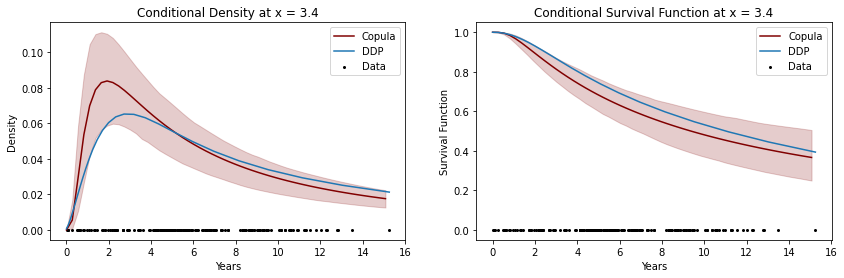

In [194]:
#Compute predictive density values
f =plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
bot25 = np.percentile(pdf_pr_copula,2.5,axis = 0)/(scale/365)
top25 = np.percentile(pdf_pr_copula,97.5,axis = 0)/(scale/365)
plt.plot(y_plot*scale/365,np.mean(pdf_pr_copula,axis = 0)/(scale/365), color = 'maroon',label = 'Copula')
plt.fill_between(y_plot*scale/365, bot25,top25,alpha = 0.2,color = 'maroon')
plt.scatter(t_norm*scale/365,np.zeros(n),color = "k",s =4,label = 'Data')
plt.plot(y_plot_ddp*scale/365, pdf_ddp/(scale/365),label = 'DDP')
plt.title(r'Conditional Density at x = 3.4')
plt.xlabel('Years')
plt.ylabel('Density')
plt.legend()

#survival
plt.subplot(1,2,2)
plt.title(r'Conditional Survival Function at x = 3.4')
bot25 = np.percentile(cdf_pr_copula,2.5,axis = 0)
top25 = np.percentile(cdf_pr_copula,97.5,axis = 0)
plt.plot(y_plot*scale/365,1-np.mean(cdf_pr_copula,axis = 0), color = 'maroon',label = 'Copula')
plt.fill_between(y_plot*scale/365, 1-bot25,1-top25,alpha = 0.2,color = 'maroon')
plt.scatter(t_norm*scale/365,np.zeros(n),color = "k",s =4,label = 'Data')
plt.plot(y_plot_ddp*scale/365, 1-cdf_ddp,label = 'DDP')
plt.xlabel('Years')
plt.ylabel('Survival Function')
plt.legend()
f.savefig("plots/melanoma_dens_surv.pdf",bbox_inches='tight')


/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1338dbee0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1338f2ca0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
/Users/efong/virtualenv/surv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <matplotlib.lines.Line2D object at 0x133901f70> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


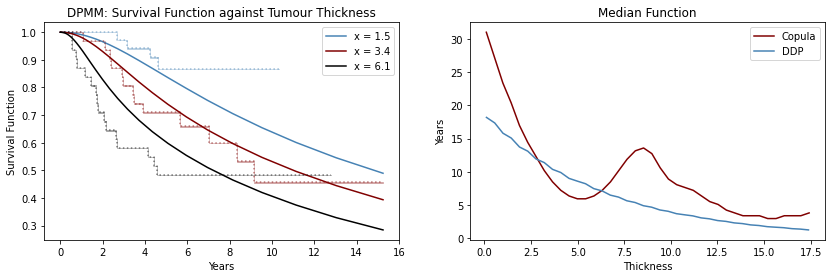

In [195]:
f =plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
from lifelines import KaplanMeierFitter
x_val = (np.array([1.5,3.4,6.1]))
y_plot_ddp = np.array(pd.read_csv('plot_files/melanoma_y_plot_ddp.csv').iloc[:,1])
col = ['steelblue','maroon','k']

x_ranges= ([(1.255,1.75),(2.7,4.1),(4.1,8.1)]-mean_x)/std_x
for i in range(3):
    x_norm_ = (x_val[i]- mean_x)/std_x
    cdf_dpmm = np.array(pd.read_csv("plot_files/melanoma_cdf_ddp_x{}.csv".format(x_val[i])).iloc[:,1])

    #cdf
    plt.plot(y_plot_ddp*scale/365,1-cdf_dpmm,label = 'x = {:.1f}'.format(x_val[i]),color = col[i])
    
    kmf = KaplanMeierFitter(alpha = 0.99)
    ind_x = np.where(np.logical_and(x_norm>x_ranges[i,0], x_norm<x_ranges[i,1]))
    kmf.fit(t_norm[ind_x]*scale/365,event_observed = delta[ind_x])
    kmf.plot(linestyle = ':',alpha = 0.5,color = col[i],label='_nolegend_')
plt.legend()
plt.title('DPMM: Survival Function against Tumour Thickness')
plt.xlabel('Years')
plt.ylabel('Survival Function')

plt.subplot(1,2,2)
plt.plot(x_grid*std_x + mean_x,median_fun*scale/365,label ='Copula',color = 'maroon')
plt.plot(x_grid_ddp*std_x + mean_x,median_fun_ddp*scale/365,label ='DDP',color = 'steelblue')

plt.xlabel('Thickness')
plt.ylabel('Years')
plt.title('Median Function')
plt.legend()
f.savefig("plots/melanoma_median_fun.pdf",bbox_inches='tight')

### Diagnostics

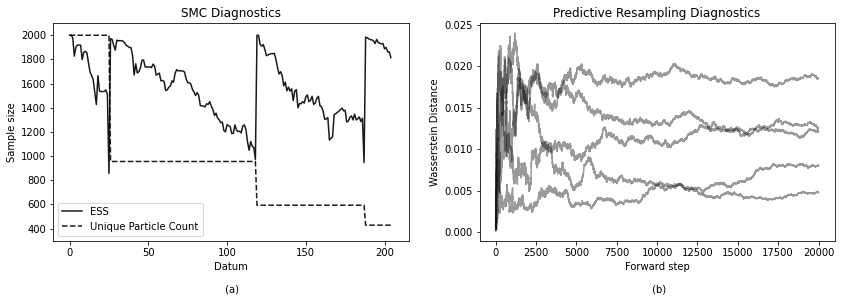

In [196]:
f =plt.figure(figsize=(14,4))
#SMC weight diagnostics
plt.subplot(1,2,1)
plt.plot(ESS_copula,label = 'ESS',color = 'k',alpha = 0.9)
plt.title('SMC Diagnostics')
n_unique = np.zeros(n+1)
for i in range(n+1):
    n_unique[i] = np.shape(np.unique(particle_ind_copula[i]))[0]
plt.plot(n_unique,label = 'Unique Particle Count',color = 'k',alpha = 0.9,linestyle = '--')
plt.xlabel('Datum'+ '\n\n (a)')
plt.ylabel('Sample size')
plt.legend(loc = 3)
plt.ylim(300,2100)


plt.subplot(1,2,2)
plt.title('Predictive Resampling Diagnostics')
#T_d = np.shape(pdiff_copula)[0]
T_d = 20000
for i in range(5):
    plt.plot(np.arange(T_d), cdiff_copula[0:T_d,i]*dy*np.shape(y_plot)[0], color = 'k',alpha = 0.4)
plt.xlabel('Forward step'+ '\n\n (b)')
plt.ylabel(r'Wasserstein Distance')
f.savefig("plots/melanoma_diagnostics.pdf",bbox_inches='tight')
